% DES431 Project 2: Recommendation System

# Background

**MovieLens** is a movie recommendation system operated by GroupLens, a research group at the University of Minnesota. 

# Task

1. Propose and implement your own recommendation system based on the MovieLens dataset. Use `ratings_train.csv` as the training set, `ratings_valid.csv` as the validation set. Your system may use information from `movies.csv` and `tags.csv` to conduct recommendations. The undisclosed test set will be used to evaluate your system.
   - The data file structure is available at https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html. 
   - The main goal of the recommendation system is to minimize the root-mean-square error.
   - The implementation should include a function named `predict_rating`. This function accepts a DataFrame with two columns `userId` and `movieId`. Then, the function adds a column named `rating` storing a predicted rating of a `movieId` by a `userId`.
   - Your program must return a root-mean-square error value when the validation set is changed to another file. Otherwise, your score will be deducted by 50%.
   - You must modify the given program to make better recommendations. Submitting the original program without modification is considered plagiarism.
2. Prepare slides for a 7-minute presentation to explain your proposed technique and algorithm to conduct recommendation, and show your RMSE results on the validation set.
3. Submit all required documents by April 30, 2023; 23:59. Late submission will not be accepted and will be marked 0. Do not wait until the last minute. Plagiarism and code duplication will be checked. 
4. Present your work on May 1, 2023 within 7 minutes. Exceeding 7 minutes will be subject to point deduction.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import imdb
import requests
import tmdb

# Loading data

In [126]:
ratings_train = pd.read_csv('ratings_train.csv')
ratings_valid = pd.read_csv('ratings_valid.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

In [61]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [62]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [73]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [141]:
ratings_train

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
96459,610,166534,4.0,1493848402
96460,610,168248,5.0,1493850091
96461,610,168250,5.0,1494273047
96462,610,168252,5.0,1493846352


In [ ]:
# get movie title and rating from IMDB
import imdb
linksIMDBID=links.copy()
linksIMDBID['imdbId'] = links['imdbId'].astype(str)

def get_movie_title_and_rating(links):
    def retrieve_info(imdbId):
        try:
            movie = ia.get_movie(imdbId)
            title = movie['title']
            rating = movie['rating']
            return title, rating
        except:
            return None, None
        
    # Apply the retrieve_info function to the imdbId column of the link_df
    movie_info = links['imdbId'].apply(retrieve_info)
    
    # Unpack the tuples into separate Series for title and rating
    movie_titles, movie_ratings = zip(*movie_info)
    
    # Return a DataFrame with the movie titles and ratings
    return pd.DataFrame({'movieId': links['movieId'], 'title': movie_titles, 'rating': movie_ratings})

# Apply the get_movie_title_and_rating function to the link DataFrame
movie_info_df = get_movie_title_and_rating(links)

## Data preprocessing

In [116]:
# remove timestamp in ratings_train
ratings = ratings_train.copy()
ratings = ratings_train.drop('timestamp', axis=1)

# convert UserID, MovieID to categorical type
ratings['userId'] = ratings['userId'].astype('category')
ratings['movieId'] = ratings['movieId'].astype('category')
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
96459,610,166534,4.0
96460,610,168248,5.0
96461,610,168250,5.0
96462,610,168252,5.0


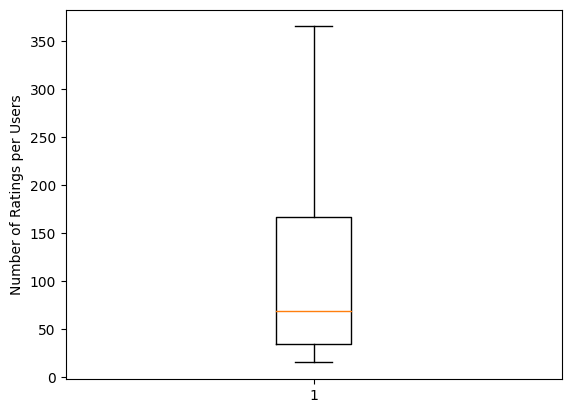

In [117]:
# filter quality user by their counts of ratings
user_counts = ratings['userId'].value_counts()

# use boxplot and get rid of outliers to find out the appropriated range of ratings count to keep
plt.boxplot(user_counts.values, showfliers=False)
plt.ylabel('Number of Ratings per Users')
plt.show()

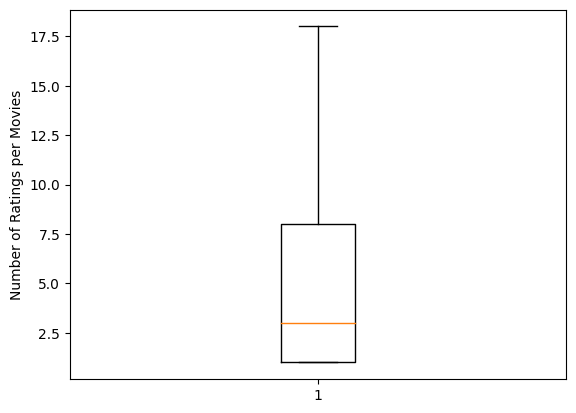

In [118]:
movie_counts = ratings['movieId'].value_counts()
plt.boxplot(movie_counts.values, showfliers=False)
plt.ylabel('Number of Ratings per Movies')
plt.show()

In [148]:
# for USER rating counts
# remove more than 350 counts
ratings_user = ratings[ratings['userId'].isin(user_counts.index[user_counts <= 350])]
ratings_user


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
95157,609,892,3.0
95158,609,1056,3.0
95159,609,1059,3.0
95160,609,1150,4.0


In [155]:
# for Movie rating counts
# remove more than 8 counts
ratings_movie = ratings_user[ratings_user['movieId'].isin(movie_counts.index[movie_counts <= 17.5])]
ratings_movie

,userId,movieId,rating
9,1,157,5.0
23,1,423,3.0
43,1,804,4.0
46,1,940,5.0
47,1,943,4.0
...,...,...,...
95156,609,833,3.0
95157,609,892,3.0
95158,609,1056,3.0
95160,609,1150,4.0


In [ ]:
# get movie title and rating from IMDB
linksIMDBID=links.copy()
linksIMDBID['imdbId'] = links['imdbId'].astype(str)

def get_movie_title_and_rating(links):
    def retrieve_info(imdbId):
        try:
            movie = ia.get_movie(imdbId)
            title = movie['title']
            rating = movie['rating']
            return title, rating
        except:
            return None, None
        
    # Apply the retrieve_info function to the imdbId column of the link_df
    movie_info = links['imdbId'].apply(retrieve_info)
    
    # Unpack the tuples into separate Series for title and rating
    movie_titles, movie_ratings = zip(*movie_info)
    
    # Return a DataFrame with the movie titles and ratings
    return pd.DataFrame({'movieId': links['movieId'], 'title': movie_titles, 'rating': movie_ratings})

# Apply the get_movie_title_and_rating function to the link DataFrame
movie_info_df = get_movie_title_and_rating(links)

In [ ]:
user_item_matrix = ratings_train.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)

In [140]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity between each pair of users
user_similarity = cosine_similarity(user_item_matrix)

# Find the top 10 most similar users to user 1
user_id = 1
similar_users = user_similarity[user_id].argsort()[::-1][1:11]

# Constructing model and predicting ratings

In [137]:
# Model construction
avg_rating = ratings_train[['movieId', 'rating']].groupby(by='movieId').mean()
	    
# Prediction
def predict_rating(df):
    # Input: 
	# 	df = a dataframe with two columns: userId, movieId
	# Output:
	#   a dataframe with three columns: userId, movieId, rating
	return df.join(avg_rating, on='movieId')


In [138]:
# Prepare df for prediction
r = ratings_valid[['userId', 'movieId']]

# Predict ratings
ratings_pred = predict_rating(r)
ratings_pred

,userId,movieId,rating
0,4,45,3.366667
1,4,52,3.520000
2,4,58,4.062500
3,4,222,3.928571
4,4,247,3.975000
...,...,...,...
2349,561,139385,3.860000
2350,561,146656,3.916667
2351,561,149406,3.416667
2352,561,160438,2.916667


In [139]:
from sklearn.metrics import mean_squared_error

r_true = ratings_valid['rating'].to_numpy()
r_pred = ratings_pred['rating'].to_numpy()

rmse = mean_squared_error(r_true, r_pred, squared=False)
print(f"RMSE = {rmse:.4f}")

RMSE = 0.9171
